# Demistifying Neural Networks
We are going to code the so-called *Vanilla Neural Network* (VNN) from the excellent post from Bernard Brenyah


https://towardsdatascience.com/how-to-build-an-artificial-neural-network-from-scratch-in-julia-c839219b3ef8 


The goal for today is going to be the implementation of a VNN from scratch, without the use of any ML package.

First and foremost, a bit of trivia: when was the concept of Neural Network invented? Most people agree on the attribution of the "invention" to the McCulloch and Pitts in **1934**!

At some basic level, Neural networks can be seen as a system which tries to take inspiration from how biological neurons share information with each other in an attempt to discover patterns within some supplied data.
Neural networks are typically composed of interconnected layers. The layers of a VNN are:
* Input
* Hidden
* Output


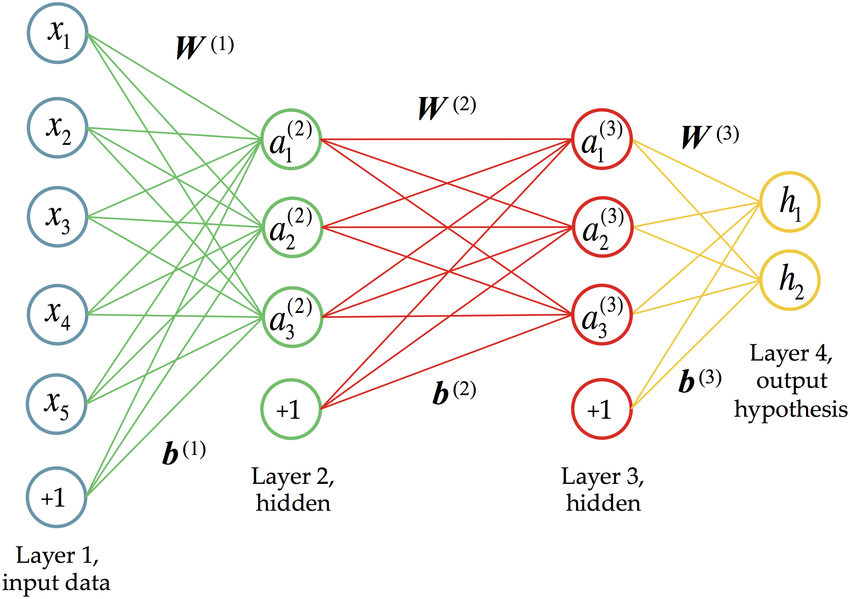

The basic mechanism is for each *Layer* to transfer information to the next one by means of appropriate mathematical functions. The aggregate of these neurons and layers make up the main parameters of a VNN.

The creation and training of the VNN requires the following 5 steps:
1. Initialization
2. Forward Propagation
3. Loss Function Estimation
4. Backpropagation
5. Parameters Update
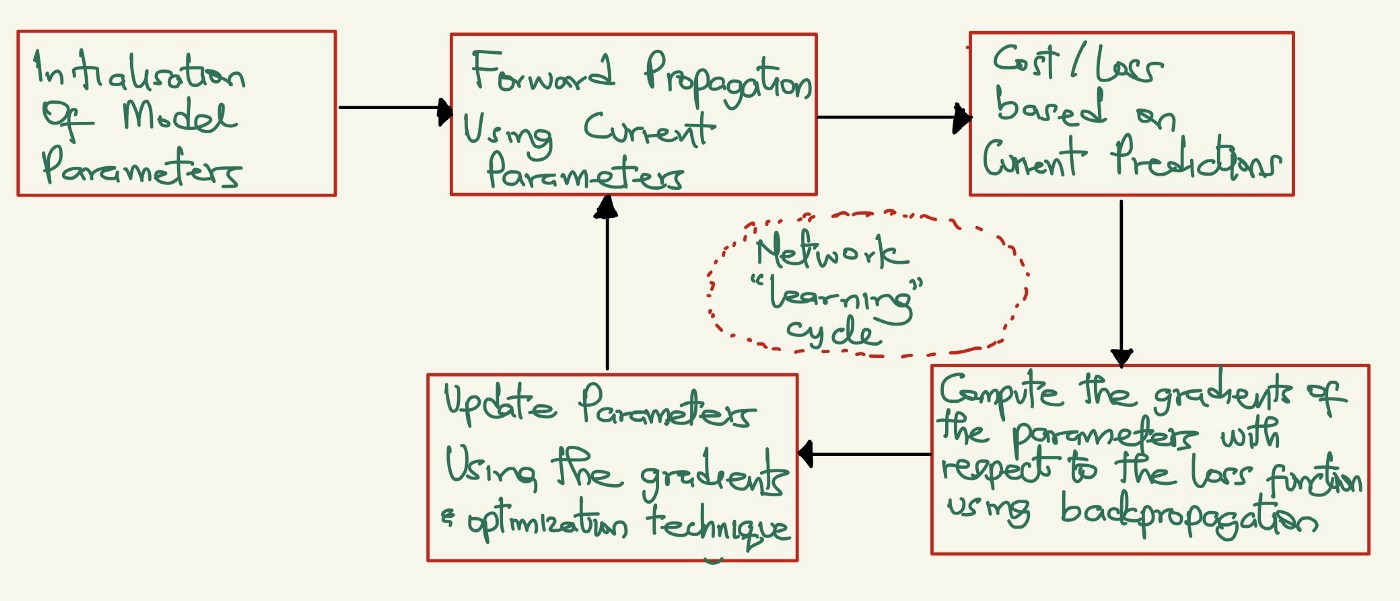

# Step 1: Initialization and Activation Functions

In [137]:
function initialise_model_weights(layer_dims, seed)
    params = Dict()

    # Build a dictionary of initialised weights and bias units
    for l=2:length(layer_dims)
        params[string("W_", (l-1))] = rand(StableRNG(seed), layer_dims[l], layer_dims[l-1]) * sqrt(2 / layer_dims[l-1])
        params[string("b_", (l-1))] = zeros(layer_dims[l], 1)
    end

    return params
end

initialise_model_weights (generic function with 1 method)

In [138]:
function sigmoid(Z)
    A = 1 ./ (1 .+ exp.(.-Z))
    return (A = A, Z = Z)
end

function relu(Z)
    A = max.(0, Z)
    return (A = A, Z = Z)
end

relu (generic function with 1 method)

# Step 2 - Forward Propagation
In this step, we "pass" the input values $X \in R^n$ to each layer (sequentially), and calculate the output (i.e., our prediction), which is in general a $Y \in R^m$

In [139]:
function linear_forward(A, W, b)
    # Make a linear forward and return inputs as cache
    Z = (W * A) .+ b
    cache = (A, W, b)

    return (Z = Z, cache = cache)
end


linear_forward (generic function with 1 method)

In [140]:
function linear_forward_activation(A_prev, W, b, activation_function="relu")

    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation_function == "sigmoid"
        A, activation_cache = sigmoid(Z)
    end

    if activation_function == "relu"
        A, activation_cache = relu(Z)
    end

    cache = (linear_step_cache=linear_cache, activation_step_cache=activation_cache)

    return A, cache
end

linear_forward_activation (generic function with 2 methods)

Now, all we need to do is to propagate the results of each layer to the next one.
**NB**: Our network will use the ReLU activator for activations upto the output layer and the sigmoid activator for the output of the network.

In [141]:
function forward_propagate_model_weights(DMatrix, parameters)
    master_cache = []
    A = DMatrix
    L = Int(length(parameters) / 2)

    # Forward propagate until the last (output) layer
    for l = 1 : (L-1)
        A_prev = A
        A, cache = linear_forward_activation(A_prev,
                                             parameters[string("W_", (l))],
                                             parameters[string("b_", (l))],
                                             "relu")
        push!(master_cache , cache)
    end

    # Make predictions in the output layer
    Ŷ, cache = linear_forward_activation(A,
                                         parameters[string("W_", (L))],
                                         parameters[string("b_", (L))],
                                         "sigmoid")
    push!(master_cache, cache)

    return Ŷ, master_cache
end

forward_propagate_model_weights (generic function with 1 method)

# Step 3 - Cost Function

The next step is to see how good those predictions are. For this objective, the network needs a cost or loss function. This cost/loss function has a simple (crucial) task which is to give a summary of how close the predictions are to the actual output values for all the training examples

Many different Cost Functions can be implemented, depending on the type of problem at hand. The most simple and straightforward choice is the MSE of the prediction if performing regression, or a Log Loss (i.e., Binary Cross Enthropy) if performing classification.

In [142]:
function calculate_cost(Ŷ, Y, cost_function="log_loss")
    
    m = size(Y, 2)
    
    if cost_function == "mse"
        cost = sum((Y-Ŷ).^2)/m
    end
    
    
    if cost_function == "log_loss"

    # Deal with log(0) scenarios
    epsilon = eps(1.0)
    Ŷ_new = [max(i, epsilon) for i in Ŷ]
    Ŷ_new = [min(i, 1-epsilon) for i in Ŷ_new]

    cost = -sum(Y .* log.(Ŷ_new) + (1 .- Y) .* log.(1 .- Ŷ_new)) / m
    end
    
    return cost
end


function assess_accuracy(Ŷ , Y)
    @assert size(Ŷ) == size(Y)
    return sum((Ŷ .> 0.5) .== Y) / length(Y)
end

assess_accuracy (generic function with 1 method)

** GREAT! ** So far, our network can take any input, and *propagate* such input to all the layers we want (**follow-up questions: how many layers and how many neurons do we want??**). At the end of the procedure, we can also compute the **Loss Function** that describes how good the prediction is.

And now?

The next step is to **improve** the ability of the VNN to cast predictions. This is where the **learning** happens!

# Step 4 - Backpropagation

The Backpropagation algorithm is the core of the *learning process* of the VNN. By back-propagating, we want to understand the how each of the parameters (all the weights & biases of all the layers) of the network changes with respect to the cost/loss function. This process allows us to turn the learning strategy into a minimisation objective where we want that cost/loss output to be a low as possible.

Ultimately, all we have to do is **tweak the parameters** — weights and biases — of the network such that it delivers the lowest value in terms of the loss/cost function. At the heart of implementation side of backpropagation, is the concept of chain rule borrowed from multivariate calculus. In fact, the whole sequence for backpropagation can be seen as a long chain of partial derivatives of each of the layers (and their weights ‘W’ and biases ‘b’ as well as linear outputs, Z) with respect to the cost/loss function. As the name connotes, this chain of sequences computes the partial derivatives, using caches that were stored during the forward propagation sequence, by going ‘backwards’ from the output layer to the input layer.

It looks like we are going to need **a lot of derivatives**! (Note: this is why the so-called *automatic differentiation* is so powerful and important in Machine Learning!

In [143]:

function sigmoid_backwards(∂A, activated_cache)
    s = sigmoid(activated_cache).A
    ∂Z = ∂A .* s .* (1 .- s)

    @assert (size(∂Z) == size(activated_cache))
    return ∂Z
end


function relu_backwards(∂A, activated_cache)
    return ∂A .* (activated_cache .> 0)
end

relu_backwards (generic function with 1 method)

With the derivative of the activation functions, let’s focus on unpacking the stored components of a linear activated output (weight, bias, & activated output of the previous layer) and computing the partial derivatives of each of them with respect to the loss function with these two functions.

In [144]:
function linear_backward(∂Z, cache)
    # Unpack cache
    A_prev , W , b = cache
    m = size(A_prev, 2)

    # Partial derivates of each of the components
    ∂W = ∂Z * (A_prev') / m
    ∂b = sum(∂Z, dims = 2) / m
    ∂A_prev = (W') * ∂Z

    return ∂W , ∂b , ∂A_prev
end

function linear_activation_backward(∂A, cache, activation_function="relu")

    linear_cache , cache_activation = cache

    if (activation_function == "relu")

        ∂Z = relu_backwards(∂A , cache_activation)
        ∂W , ∂b , ∂A_prev = linear_backward(∂Z , linear_cache)

    elseif (activation_function == "sigmoid")

        ∂Z = sigmoid_backwards(∂A , cache_activation)
        ∂W , ∂b , ∂A_prev = linear_backward(∂Z , linear_cache)

    end

    return ∂W , ∂b , ∂A_prev
end

linear_activation_backward (generic function with 2 methods)

In [145]:
function back_propagate_model_weights(Ŷ, Y, master_cache)
    # Initiate the dictionary to store the gradients for all the components in each layer
    ∇ = Dict()

    L = length(master_cache)
    Y = reshape(Y , size(Ŷ))

    # Partial derivative of the output layer
    ∂Ŷ = (-(Y ./ Ŷ) .+ ((1 .- Y) ./ ( 1 .- Ŷ)))
    current_cache = master_cache[L]

    # Backpropagate on the layer preceeding the output layer
    ∇[string("∂W_", (L))], ∇[string("∂b_", (L))], ∇[string("∂A_", (L-1))] = linear_activation_backward(∂Ŷ,
                                                                                                       current_cache,
                                                                                                       "sigmoid")
    # Go backwards in the layers and compute the partial derivates of each component.
    for l=reverse(0:L-2)
        current_cache = master_cache[l+1]
        ∇[string("∂W_", (l+1))], ∇[string("∂b_", (l+1))], ∇[string("∂A_", (l))] = linear_activation_backward(∇[string("∂A_", (l+1))],
                                                                                                             current_cache,
                                                                                                             "relu")
    end

    # Return the gradients of the network
    return ∇
end


back_propagate_model_weights (generic function with 1 method)

# Step 5 - Update Weights (Optimization)

We are basically there! Our network is taking shape now. When given some layers as an architecture, it can initiate the parameters/weights of these layers randomly, generate some random predictions thereof and quantify how right or wrong overall it is from the ground truth.

Gradient Descent is one of the most popular optimization techniques for find the best parameters of such a network.

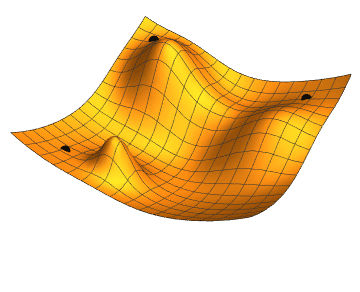

In [146]:
function update_model_weights(parameters, ∇, η)

    L = Int(length(parameters) / 2)

    # Update the parameters (weights and biases) for all the layers
    for l = 1:L
        parameters[string("W_", (l))] -= η .* ∇[string("∂W_", (l))]
        parameters[string("b_", (l))] -= η .* ∇[string("∂b_", (l))]
    end

    return parameters
end

update_model_weights (generic function with 1 method)

# Put it all Together - Build the Network

The training of a neural neural is basically the chain of sequence where input data are forwarded through the network using available parameters of this network, predictions compared to the actual training data predictions and then finally the tweaking of the parameters as a method of improving predictions. Each run of this sequence is referred to as an *epoch*.

In [147]:
function train_network(layer_dims , DMatrix, Y;  η=0.001, epochs=1000, seed=2020, verbose=true)
    # Initiate an empty container for cost, iterations, and accuracy at each iteration
    costs = []
    iters = []
    accuracy = []

    # Initialise random weights for the network
    params = initialise_model_weights(layer_dims, seed)

    # Train the network
    for i = 1:epochs

        Ŷ , caches  = forward_propagate_model_weights(DMatrix, params)
        cost = calculate_cost(Ŷ, Y)
        acc = assess_accuracy(Ŷ, Y)
        ∇  = back_propagate_model_weights(Ŷ, Y, caches)
        params = update_model_weights(params, ∇, η)

        if verbose
            println("Iteration -> $i, Cost -> $cost, Accuracy -> $acc")
        end

        # Update containers for cost, iterations, and accuracy at the current iteration (epoch)
        push!(iters , i)
        push!(costs , cost)
        push!(accuracy , acc)
    end
        return (cost = costs, iterations = iters, accuracy = accuracy, parameters = params)
end

train_network (generic function with 1 method)

Iteration -> 1, Cost -> 4.406282402343262, Accuracy -> 0.5
Iteration -> 2, Cost -> 3.441224764471401, Accuracy -> 0.5
Iteration -> 3, Cost -> 2.666010290127382, Accuracy -> 0.5
Iteration -> 4, Cost -> 2.03943069194285, Accuracy -> 0.5
Iteration -> 5, Cost -> 1.5397609578170097, Accuracy -> 0.5
Iteration -> 6, Cost -> 1.1596140128077863, Accuracy -> 0.5
Iteration -> 7, Cost -> 0.8951523447072725, Accuracy -> 0.5
Iteration -> 8, Cost -> 0.7308006618575855, Accuracy -> 0.5
Iteration -> 9, Cost -> 0.6365323156334148, Accuracy -> 0.5362
Iteration -> 10, Cost -> 0.5823769946769269, Accuracy -> 0.9362
Iteration -> 11, Cost -> 0.5487530850522386, Accuracy -> 0.9994
Iteration -> 12, Cost -> 0.5253073695164208, Accuracy -> 0.998
Iteration -> 13, Cost -> 0.5068219106197709, Accuracy -> 0.9976
Iteration -> 14, Cost -> 0.49074054591093225, Accuracy -> 0.9979
Iteration -> 15, Cost -> 0.47587884001440645, Accuracy -> 0.9988
Iteration -> 16, Cost -> 0.4616641050041757, Accuracy -> 0.9995
Iteration -> 

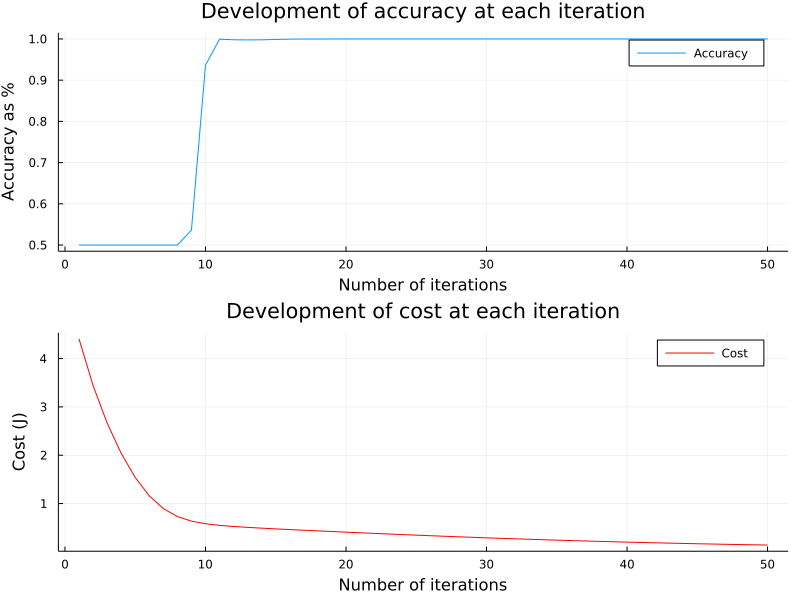

In [156]:
using Plots
using MLJBase
using StableRNGs # Seeding generator for reproducibility

# Generate fake data
X, y = make_blobs(10_000, 3; centers=2, as_table=false, rng=2020);
X = Matrix(X');
y = reshape(y, (1, size(X, 2)));
f(x) =  x == 2 ? 0 : x
#f(x) = x^3 + randn(1)
y2 = f.(y);

# Input dimensions
input_dim = size(X, 1);

# Train the model
nn_results = train_network([input_dim, 5, 3, 1], X, y2; η=0.01, epochs=50, seed=1, verbose=true);

# Plot accuracy per iteration
p1 = plot(nn_results.accuracy,
         label="Accuracy",
         xlabel="Number of iterations",
         ylabel="Accuracy as %",
         title="Development of accuracy at each iteration");

# Plot cost per iteration 
p2 = plot(nn_results.cost,
         label="Cost",
         xlabel="Number of iterations",
         ylabel="Cost (J)",
         color="red",
         title="Development of cost at each iteration");

# Combine accuracy and cost plots
plot(p1, p2, layout = (2, 1), size = (800, 600))

In [157]:
X

3×10000 Matrix{Float64}:
 -7.6909   8.23877   9.74321   -5.4276   …   7.98436    8.84757  -5.91485
  7.49614  7.74089   8.19203    7.69664      6.37353    8.03602   6.0597
  7.39913  0.154709  0.467068   9.29682     -0.0726649  1.21324   9.20064

Iteration -> 1, Cost -> 1.1766582677245976, Accuracy -> 0.0
Iteration -> 2, Cost -> 1.1549703614098394, Accuracy -> 0.0
Iteration -> 3, Cost -> 1.1343979403022022, Accuracy -> 0.0
Iteration -> 4, Cost -> 1.1147723996066377, Accuracy -> 0.0
Iteration -> 5, Cost -> 1.0959436398309073, Accuracy -> 0.0
Iteration -> 6, Cost -> 1.0778329326441194, Accuracy -> 0.0
Iteration -> 7, Cost -> 1.0604117501448334, Accuracy -> 0.0
Iteration -> 8, Cost -> 1.0435050137732735, Accuracy -> 0.0
Iteration -> 9, Cost -> 1.026968603082216, Accuracy -> 0.0
Iteration -> 10, Cost -> 1.0110516906032938, Accuracy -> 0.0
Iteration -> 11, Cost -> 0.9957600185943787, Accuracy -> 0.0
Iteration -> 12, Cost -> 0.9810243039654247, Accuracy -> 0.0
Iteration -> 13, Cost -> 0.9669931463280796, Accuracy -> 0.0
Iteration -> 14, Cost -> 0.9535135508487579, Accuracy -> 0.0
Iteration -> 15, Cost -> 0.9405153591640544, Accuracy -> 0.0
Iteration -> 16, Cost -> 0.9279312014307455, Accuracy -> 0.0
Iteration -> 17, Cost -> 0.9157499

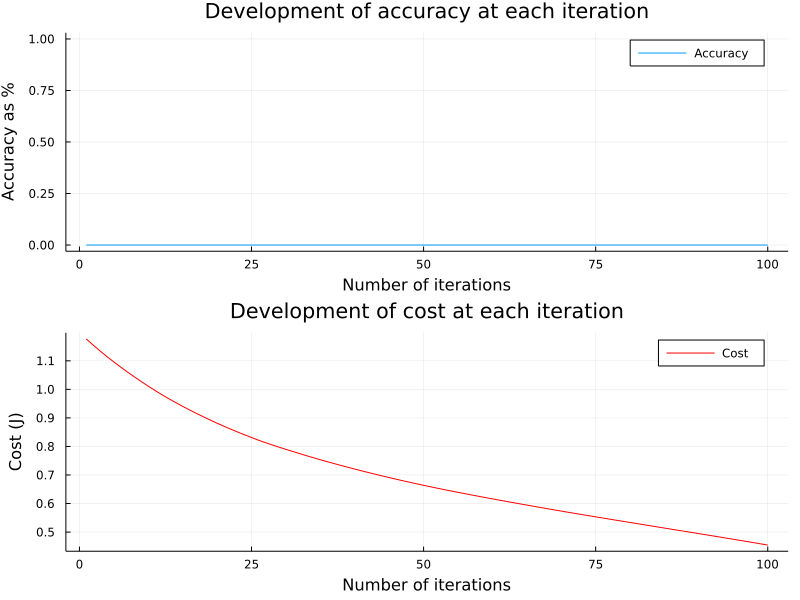

In [163]:
using MLJBase
X, y = make_regression(100, 5; noise=0.5, sparse=0.2, outliers=0.1)
X = matrix(X)
X = X';
y = reshape(y, (1, size(X, 2)));
y2 = y

# Input dimensions
input_dim = size(X, 1);

# Train the model
nn_results = train_network([input_dim, 5, 3, 1], X, y2; η=0.01, epochs=100, seed=1, verbose=true);

# Plot accuracy per iteration
p1 = plot(nn_results.accuracy,
         label="Accuracy",
         xlabel="Number of iterations",
         ylabel="Accuracy as %",
         title="Development of accuracy at each iteration");

# Plot cost per iteration 
p2 = plot(nn_results.cost,
         label="Cost",
         xlabel="Number of iterations",
         ylabel="Cost (J)",
         color="red",
         title="Development of cost at each iteration");

# Combine accuracy and cost plots
plot(p1, p2, layout = (2, 1), size = (800, 600))
